# Play Golf — Decision Tree (ID3 / Entropy)

Notebook ini mereplikasi contoh *PlayGolf* dengan:

1. Membuat dataset.
2. Menghitung **Entropy** & **Information Gain** (versi manual).
3. Melatih **Decision Tree (criterion='entropy')** dari scikit-learn.
4. Mencetak struktur pohon dan memetakan label kategori → angka.

> Catatan: Untuk model pohon, _LabelEncoder_ aman dipakai, tetapi untuk model lain (linear/KNN) lebih baik **One-Hot Encoding**.

In [1]:
# 1) Import library
import pandas as pd
import numpy as np
from math import log2
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)

## Dataset PlayGolf

In [2]:
# 2) Buat dataset PlayGolf (14 baris)
data = {
    'Outlook': ['Rainy', 'Rainy', 'Overcast', 'Sunny', 'Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 'Sunny', 'Rainy', 'Overcast', 'Overcast', 'Sunny'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': [False, True, False, False, False, True, True, False, False, False, True, True, False, True],
    'PlayGolf': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)
df

,Outlook,Temp,Humidity,Windy,PlayGolf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


## Entropy & Information Gain (manual)

In [3]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    return float(np.sum([(-counts[i]/np.sum(counts)) * log2(counts[i]/np.sum(counts)) for i in range(len(elements))]))

def info_gain(data, split_attribute_name, target_name="PlayGolf"):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(
            data.where(data[split_attribute_name] == vals[i]).dropna()[target_name]
        ) for i in range(len(vals))
    ])
    return float(total_entropy - weighted_entropy)

In [4]:
# 3) Hitung Entropy & IG untuk tiap fitur
print("Entropy (PlayGolf):", round(entropy(df["PlayGolf"]), 4))
for col in df.columns[:-1]:
    print(f"Information Gain ({col}):", round(info_gain(df, col), 4))

Entropy (PlayGolf): 0.9852
Information Gain (Outlook): 0.3806
Information Gain (Temp): 0.0391
Information Gain (Humidity): 0.0611
Information Gain (Windy): 0.1281


## Latih Decision Tree (entropy) & cetak strukturnya

In [5]:
# 4) Encode kategori → numerik, latih pohon, dan cetak struktur
df_encoded = df.copy()
encoders = {}
for col in df.columns:
    if df[col].dtype == object:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])
        encoders[col] = le

X = df_encoded.drop(columns=['PlayGolf'])
y = df_encoded['PlayGolf']

clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X, y)

print(export_text(clf, feature_names=list(X.columns)))

|--- Outlook <= 0.50
|   |--- class: 1
|--- Outlook >  0.50
|   |--- Windy <= 0.50
|   |   |--- Outlook <= 1.50
|   |   |   |--- Humidity <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Humidity >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Outlook >  1.50
|   |   |   |--- class: 1
|   |--- Windy >  0.50
|   |   |--- class: 0



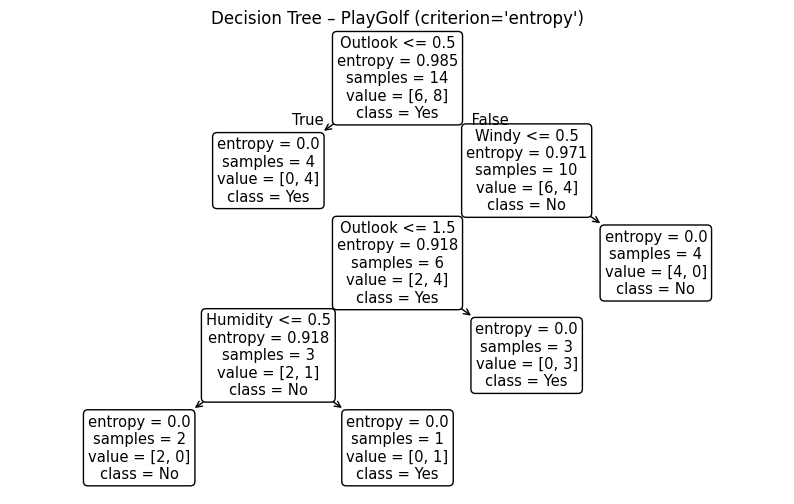

In [6]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Gunakan model & variabel yang telah dibuat (clf, X, encoders)
plt.figure(figsize=(10, 6))
plot_tree(
    clf,
    feature_names=list(X.columns),
    class_names=list(encoders['PlayGolf'].classes_),
    filled=False,

)
plt.title("Decision Tree – PlayGolf (criterion='entropy')")
plt.show()

### Mapping LabelEncoder untuk interpretasi ambang (<= 0.5, dst.)

In [ ]:
for col, le in encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col}: {mapping}")

## (Opsional) Coba prediksi beberapa contoh baru

In [ ]:
samples = pd.DataFrame([
    {"Outlook": "Overcast", "Temp": "Mild", "Humidity": "High", "Windy": False},
    {"Outlook": "Sunny", "Temp": "Mild", "Humidity": "Normal", "Windy": False},
    {"Outlook": "Rainy", "Temp": "Cool", "Humidity": "Normal", "Windy": True},
])

# Encode memakai encoder yang sama
samples_enc = samples.copy()
for col, le in encoders.items():
    if col in samples_enc.columns:
        samples_enc[col] = le.transform(samples_enc[col])

pred = clf.predict(samples_enc)
pred_label = encoders['PlayGolf'].inverse_transform(pred)
pd.concat([samples, pd.Series(pred_label, name='Predicted_PlayGolf')], axis=1)